In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import torch

if not torch.cuda.is_available():
    raise Exception('GPU not available.')

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('gpu')

SEED = 42
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

print(f'Device: {torch.cuda.get_device_name(0)} | Seed: {SEED}' )

Device: NVIDIA GeForce GTX 1060 6GB | Seed: 42


In [3]:
import os

DATA_FOLDER = 'data'
SCRIPT_FOLDER = 'scripts'

archive_path = os.path.join(DATA_FOLDER, 'archive.zip')
CLOUD_TEST_PATH = os.path.join(DATA_FOLDER, '38-Cloud_test')
CLOUD_TRAIN_PATH = os.path.join(DATA_FOLDER, '38-Cloud_training')

# flag to check if archive.zip has already been unzipped
is_archive_unzipped = os.path.exists(CLOUD_TEST_PATH) and os.path.exists(CLOUD_TRAIN_PATH)

# raise error if archive.zip has not been found and it has not been unzipped yet
if not os.path.exists(archive_path) and not is_archive_unzipped:
    raise Exception('Error: archive.zip is missing from data folder')

if is_archive_unzipped:
    print('Archive already unzipped.')

Archive already unzipped.


In [4]:
if (is_archive_unzipped == False):
    print('Unzipping archive...')
    !unzip data/archive.zip -d data
    print('Archive Unzipped!')    

In [5]:
if os.path.exists(archive_path) and is_archive_unzipped:
    !rm data/archive.zip
    print('Archive Removed!')

In [6]:
if not os.path.exists('data/38-Cloud_test/test_gt'):
    print('Building test gt...')
    !python3 scripts/build_test_gt.py    

In [7]:
if not os.path.exists('data/testing_patches_38-cloud_nonempty.csv'):
    print('Building test patches...')
    !python3 scripts/build_nonempty.py

In [8]:
train_patches_name = 'training_patches_38-Cloud.csv'
test_patches_name = 'test_patches_38-Cloud.csv'

df_patches_train = pd.read_csv(os.path.join(CLOUD_TRAIN_PATH, train_patches_name))  # patches from 38-Cloud_training
df_patches_train['type'] = 'train'
df_patches_test = pd.read_csv(os.path.join(CLOUD_TEST_PATH, test_patches_name))     # patches from 38-Cloud_test
df_patches_test['type'] = 'test'

df_patches=pd.concat([df_patches_train,df_patches_test]).reset_index(drop=True)     # concatenate the two dataframes

print(f'Patches from train: {len(df_patches_train)} | Patches from test: {len(df_patches_test)}')
#df_patches.head()

tr_non_empty_patches_name = 'training_patches_38-cloud_nonempty.csv'
df_patches_train_non_empty = pd.read_csv(os.path.join(DATA_FOLDER, tr_non_empty_patches_name))
df_patches_train_non_empty['type'] = 'train'
print (f'Number of non-empty training patches: {len(df_patches_train_non_empty)}')

ts_non_empty_patches_name = 'testing_patches_38-cloud_nonempty.csv'
df_patches_test_non_empty = pd.read_csv(os.path.join(DATA_FOLDER, ts_non_empty_patches_name))
df_patches_test_non_empty['type'] = 'test'
print (f'Number of non-empty testing patches: {len(df_patches_test_non_empty)}')


Patches from train: 8400 | Patches from test: 9201
Number of non-empty training patches: 5155
Number of non-empty testing patches: 5009


In [9]:
from torch.utils.data import Dataset, Subset, random_split
from pathlib import Path
from PIL import Image

class Cloud38Dataset(Dataset):
    def __init__(self, patches_df, transform=None):
        super().__init__()        
        self.transform = transform
        self.patches = [self.map_patches(f, t) for f, t in zip(patches_df['name'], patches_df['type'])]           
        self.mean = None
        self.std = None

    def map_patches(self, file_name, type_p):

        folder_path = Path(CLOUD_TEST_PATH) if type_p == 'test' else Path(CLOUD_TRAIN_PATH)

        channels = ['red', 'green', 'blue', 'nir', 'gt']
        paths = {}

        for i in channels:
            path = folder_path / Path(f'{type_p}_{i}') / Path(f'{i}_' + file_name + '.TIF')
            if not os.path.exists(path):
                raise Exception(f'Error: {path} does not exist' )
            paths[i] = path   

        return paths
    
    def __len__(self):
        return len(self.patches)

    def to_array(self, i, invert=False, include_nir=False):
        rgb = np.stack([
            np.array(Image.open(self.patches[i]['red'])),
            np.array(Image.open(self.patches[i]['green'])),
            np.array(Image.open(self.patches[i]['blue'])),
        ], axis=2)

        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.patches[i]['nir'])), axis=2)
            rgb = np.concatenate([rgb, nir], axis=2)

        if invert: # Torch wants the color channel first, so Color x Height x Width
            rgb = rgb.transpose((2, 0, 1))
        
        return rgb / np.iinfo(rgb.dtype).max # images are uint16, so max is 65535
          
    
    def to_mask(self, i, add_dims=False):
        mask = np.array(Image.open(self.patches[i]['gt']))
        mask = np.where(mask == 255, 1, 0)

        if add_dims:
            return np.expand_dims(mask, 0)
        else:
            return mask
        
    def __getitem__(self, i):         
        img = self.to_array(i, invert=False)
        mask = self.to_mask(i)

        #print(f'Image shape: {img.shape} | Mask shape: {mask.shape}')        

        # Apply transformations if defined
        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img = augmentations['image']
            mask = augmentations['mask']
            # Return type is Tensor

        else:        
            img = torch.tensor(img.transpose(2, 0, 1), dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32)

        return img, mask        

In [62]:
# Setup custom cmap for mask
custom_cmap = plt.colormaps['viridis']  # We change the default colormap to make sure that 0 is purple and 1 is yellow
custom_cmap.set_under('purple')         # Wven when the mask has only 0s or 1s
custom_cmap.set_over('yellow')

print(custom_cmap)

In [11]:
# Load of training dataset
data_train = Cloud38Dataset(df_patches_train_non_empty)     # We use non empty patches for more efficient training
print(f'Loaded Training data   | Length: {len(data_train)}')

data_test_val = Cloud38Dataset(df_patches_test_non_empty, transform=None)
dtv_len2 = len(data_test_val) // 2
data_test, data_val = random_split(data_test_val, [dtv_len2 + 1, dtv_len2])
print(f'Loaded Testing data    | Length: {len(data_test)}')
print(f'Loaded Validation data | Length: {len(data_val)}')

Loaded Training data   | Length: 5155
Loaded Testing data    | Length: 2505
Loaded Validation data | Length: 2504


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(384, 384)


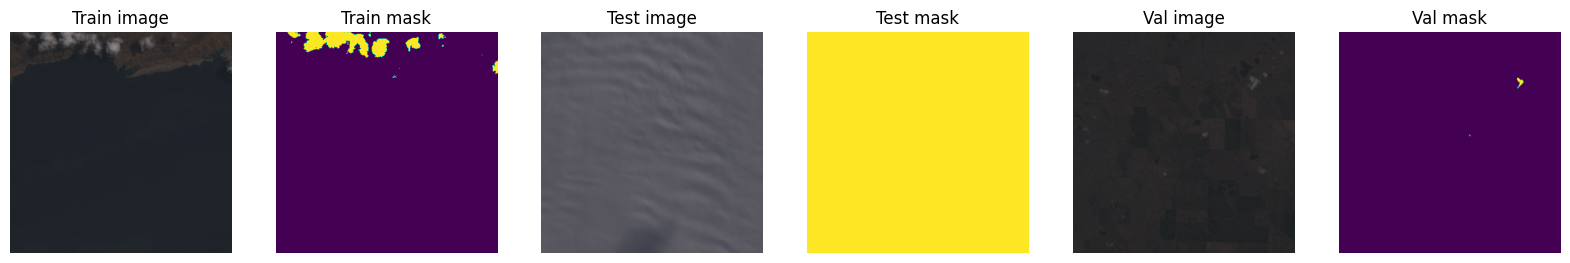

In [37]:
train_index = np.random.randint(0, len(data_train))
test_index = np.random.randint(0, len(data_test))
val_index = np.random.randint(0, len(data_val))

idxs = {'train': train_index, 'test': test_index, 'val': val_index}

fig, ax = plt.subplots(1, 6, figsize=(20, 15))

x = 0
for i, j in enumerate(idxs):
    ax[i*2].imshow(data_train.to_array(idxs[j]))
    ax[i*2].set_title(f'{j.capitalize()} image')
    ax[i*2].set_axis_off()
    ax[i*2+1].imshow(data_train.to_mask(idxs[j]), cmap=custom_cmap, vmin=0, vmax=1)
    ax[i*2+1].set_title(f'{j.capitalize()} mask')
    ax[i*2+1].set_axis_off()

#print(data_train.to_array(train_index))


print(data_train.to_mask(train_index))
print(data_train.to_mask(train_index).shape)
        


In [13]:
from torch.utils.data import DataLoader
IMAGE_SIZE = 384

if False: # Temporary flag to disable mean and std computation
    loader_train = DataLoader(data_train, batch_size=32)

    pixel_sum = torch.tensor([0.0, 0.0, 0.0])
    pixel_sum_sq = torch.tensor([0.0, 0.0, 0.0])

    for x, y in loader_train:
        pixel_sum += x.sum(axis=(0, 2, 3))
        pixel_sum_sq += (x ** 2).sum(axis=(0, 2, 3))

    count = len(data_train) * IMAGE_SIZE * IMAGE_SIZE
    mean = pixel_sum / count
    var = (pixel_sum_sq / count) - (mean ** 2)
    std = torch.sqrt(var)

else:
    mean = torch.tensor([0.2400, 0.2366, 0.2508])
    std = torch.tensor([0.1451, 0.1393, 0.1443])

print(f'Computed mean and std for the dataset:\n Mean: {mean} | Std: {std}')

Computed mean and std for the dataset:
 Mean: tensor([0.2400, 0.2366, 0.2508]) | Std: tensor([0.1451, 0.1393, 0.1443])


In [14]:
# Define Hyperparameters for training
LEARNING_RATE = 1e-7
DEVICE = device
BATCH_SIZE = 16
NUM_EPOCHS = 10
IMAGE_RESIZE = 128
PIN_MEMORY = True
LOAD_MODEL= True # True if you want to load a previous model from the checkpoint.pth.tar file
MODELS_FOLDER = 'models'
SUBSET_SIZE = 1000
NORMALIZE = True

In [15]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose([    
    A.Resize(height=IMAGE_RESIZE, width=IMAGE_RESIZE),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.Normalize(
    mean=mean.tolist(),   # mean=mean.tolist() | mean=[0.0, 0.0, 0.0]
    std=std.tolist(),     # std=std.tolist()   | std=[1.0, 1.0, 1.0]
    max_pixel_value=1,    
    ),
    ToTensorV2(),       
])

val_transforms = A.Compose([    
    A.Resize(height=IMAGE_RESIZE, width=IMAGE_RESIZE),
    A.Normalize(
    mean=mean.tolist(),  
    std=std.tolist(),   
    max_pixel_value=1,    
    ),
    ToTensorV2(),       
])

if NORMALIZE: # True for training with augmentations
    sub_train = Cloud38Dataset(df_patches_train_non_empty, transform=train_transform)
    sub_val = Cloud38Dataset(df_patches_test_non_empty, transform=val_transforms)
else:
    sub_train = Cloud38Dataset(df_patches_train_non_empty, transform=None)
    sub_val = Cloud38Dataset(df_patches_test_non_empty, transform=None)

sub_train = Subset(sub_train, np.random.randint(0, len(data_train), SUBSET_SIZE),)
sub_val = Subset(sub_val, np.random.randint(0, len(data_val), SUBSET_SIZE))

print(f'Length of sub_train: {len(sub_train)} | Length of sub_val: {len(sub_val)}')


Length of sub_train: 1000 | Length of sub_val: 1000


Normalized image sits between -0.8534711599349976 and 3.8751583099365234
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        ...,
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1]], dtype=torch.int32)


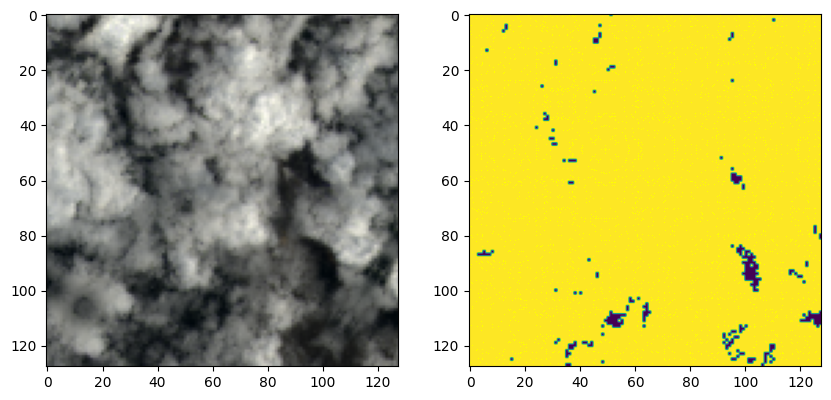

In [85]:
# Let's check the output of normalization
dl_normalized = DataLoader(sub_train, shuffle=True)
for x, y in dl_normalized:
    z = x[0].permute(1, 2, 0)
    z = (z - z.min()) / (z.max() - z.min())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(z)    
    ax[1].imshow(y[0], cmap=custom_cmap, vmin=0, vmax=1)   
    print(f'Normalized image sits between {x.min()} and {x.max()}')    
    break

print((y[0]))

In [17]:
import torch.nn as nn
import torch.optim as optim
from model import UNET
from tqdm import tqdm
from utils import (
    load_checkpoint, 
    save_checkpoint,    
    check_accuracy,
    save_predictions_as_imgs,
)

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)    

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            #print(f'Predictions shape: {predictions.shape} | Targets shape: {targets.shape}')
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

def main():    
    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss() # Binary Cross Entropy with Logits
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_loader = DataLoader(
        dataset=sub_train,
        batch_size=BATCH_SIZE,
        shuffle=True,        
        pin_memory=PIN_MEMORY,
    )

    val_loader = DataLoader(
        dataset=sub_val,
        batch_size=1,
        shuffle=False,        
        pin_memory=PIN_MEMORY,
    )

    model_path = os.path.join(MODELS_FOLDER, 'unet.pth.tar')
    if LOAD_MODEL:
        load_checkpoint(torch.load(model_path), model)               

    scaler = torch.cuda.amp.GradScaler()
    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)         

        # save model
        checkpoint = {
            'state_dict': model.state_dict(),
            #'optimizer': optimizer.state_dict(),
        }
        save_checkpoint(checkpoint, filename=model_path)
        
        # check acc
        check_accuracy(val_loader, model, device=DEVICE)
        
        #save
        save_predictions_as_imgs(
            val_loader, model, folder='imgs/', device=DEVICE
        )

        print(f"Epoch {epoch} completed!")       


if __name__ == "__main__":
    main()

Loading checkpoint


100%|██████████| 63/63 [00:28<00:00,  2.17it/s, loss=0.468]


Saving checkpoint
Got 13799259/16384000 with acc 84.22
Dice score: 0.5795250535011292
Epoch 0 completed!


100%|██████████| 63/63 [00:25<00:00,  2.51it/s, loss=0.495]


Saving checkpoint
Got 13942874/16384000 with acc 85.10
Dice score: 0.5858913660049438
Epoch 1 completed!


100%|██████████| 63/63 [00:24<00:00,  2.55it/s, loss=0.603]


Saving checkpoint
Got 13929576/16384000 with acc 85.02
Dice score: 0.5848968625068665
Epoch 2 completed!


100%|██████████| 63/63 [00:24<00:00,  2.55it/s, loss=0.408]


Saving checkpoint
Got 13922975/16384000 with acc 84.98
Dice score: 0.5854663848876953
Epoch 3 completed!


100%|██████████| 63/63 [00:24<00:00,  2.53it/s, loss=0.642]


Saving checkpoint
Got 13564504/16384000 with acc 82.79
Dice score: 0.5569572448730469
Epoch 4 completed!


100%|██████████| 63/63 [00:24<00:00,  2.53it/s, loss=0.404]


Saving checkpoint
Got 13828560/16384000 with acc 84.40
Dice score: 0.5755735039710999
Epoch 5 completed!


100%|██████████| 63/63 [00:24<00:00,  2.57it/s, loss=0.474]


Saving checkpoint
Got 13696955/16384000 with acc 83.60
Dice score: 0.5604767203330994
Epoch 6 completed!


100%|██████████| 63/63 [00:24<00:00,  2.55it/s, loss=0.508]


Saving checkpoint
Got 13645176/16384000 with acc 83.28
Dice score: 0.5581153035163879
Epoch 7 completed!


100%|██████████| 63/63 [00:24<00:00,  2.57it/s, loss=0.522]


Saving checkpoint
Got 13861935/16384000 with acc 84.61
Dice score: 0.5745669007301331
Epoch 8 completed!


100%|██████████| 63/63 [00:24<00:00,  2.54it/s, loss=0.443]


Saving checkpoint
Got 14033879/16384000 with acc 85.66
Dice score: 0.5953015685081482
Epoch 9 completed!


Random results range: [ 5 27 10  7 20]
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


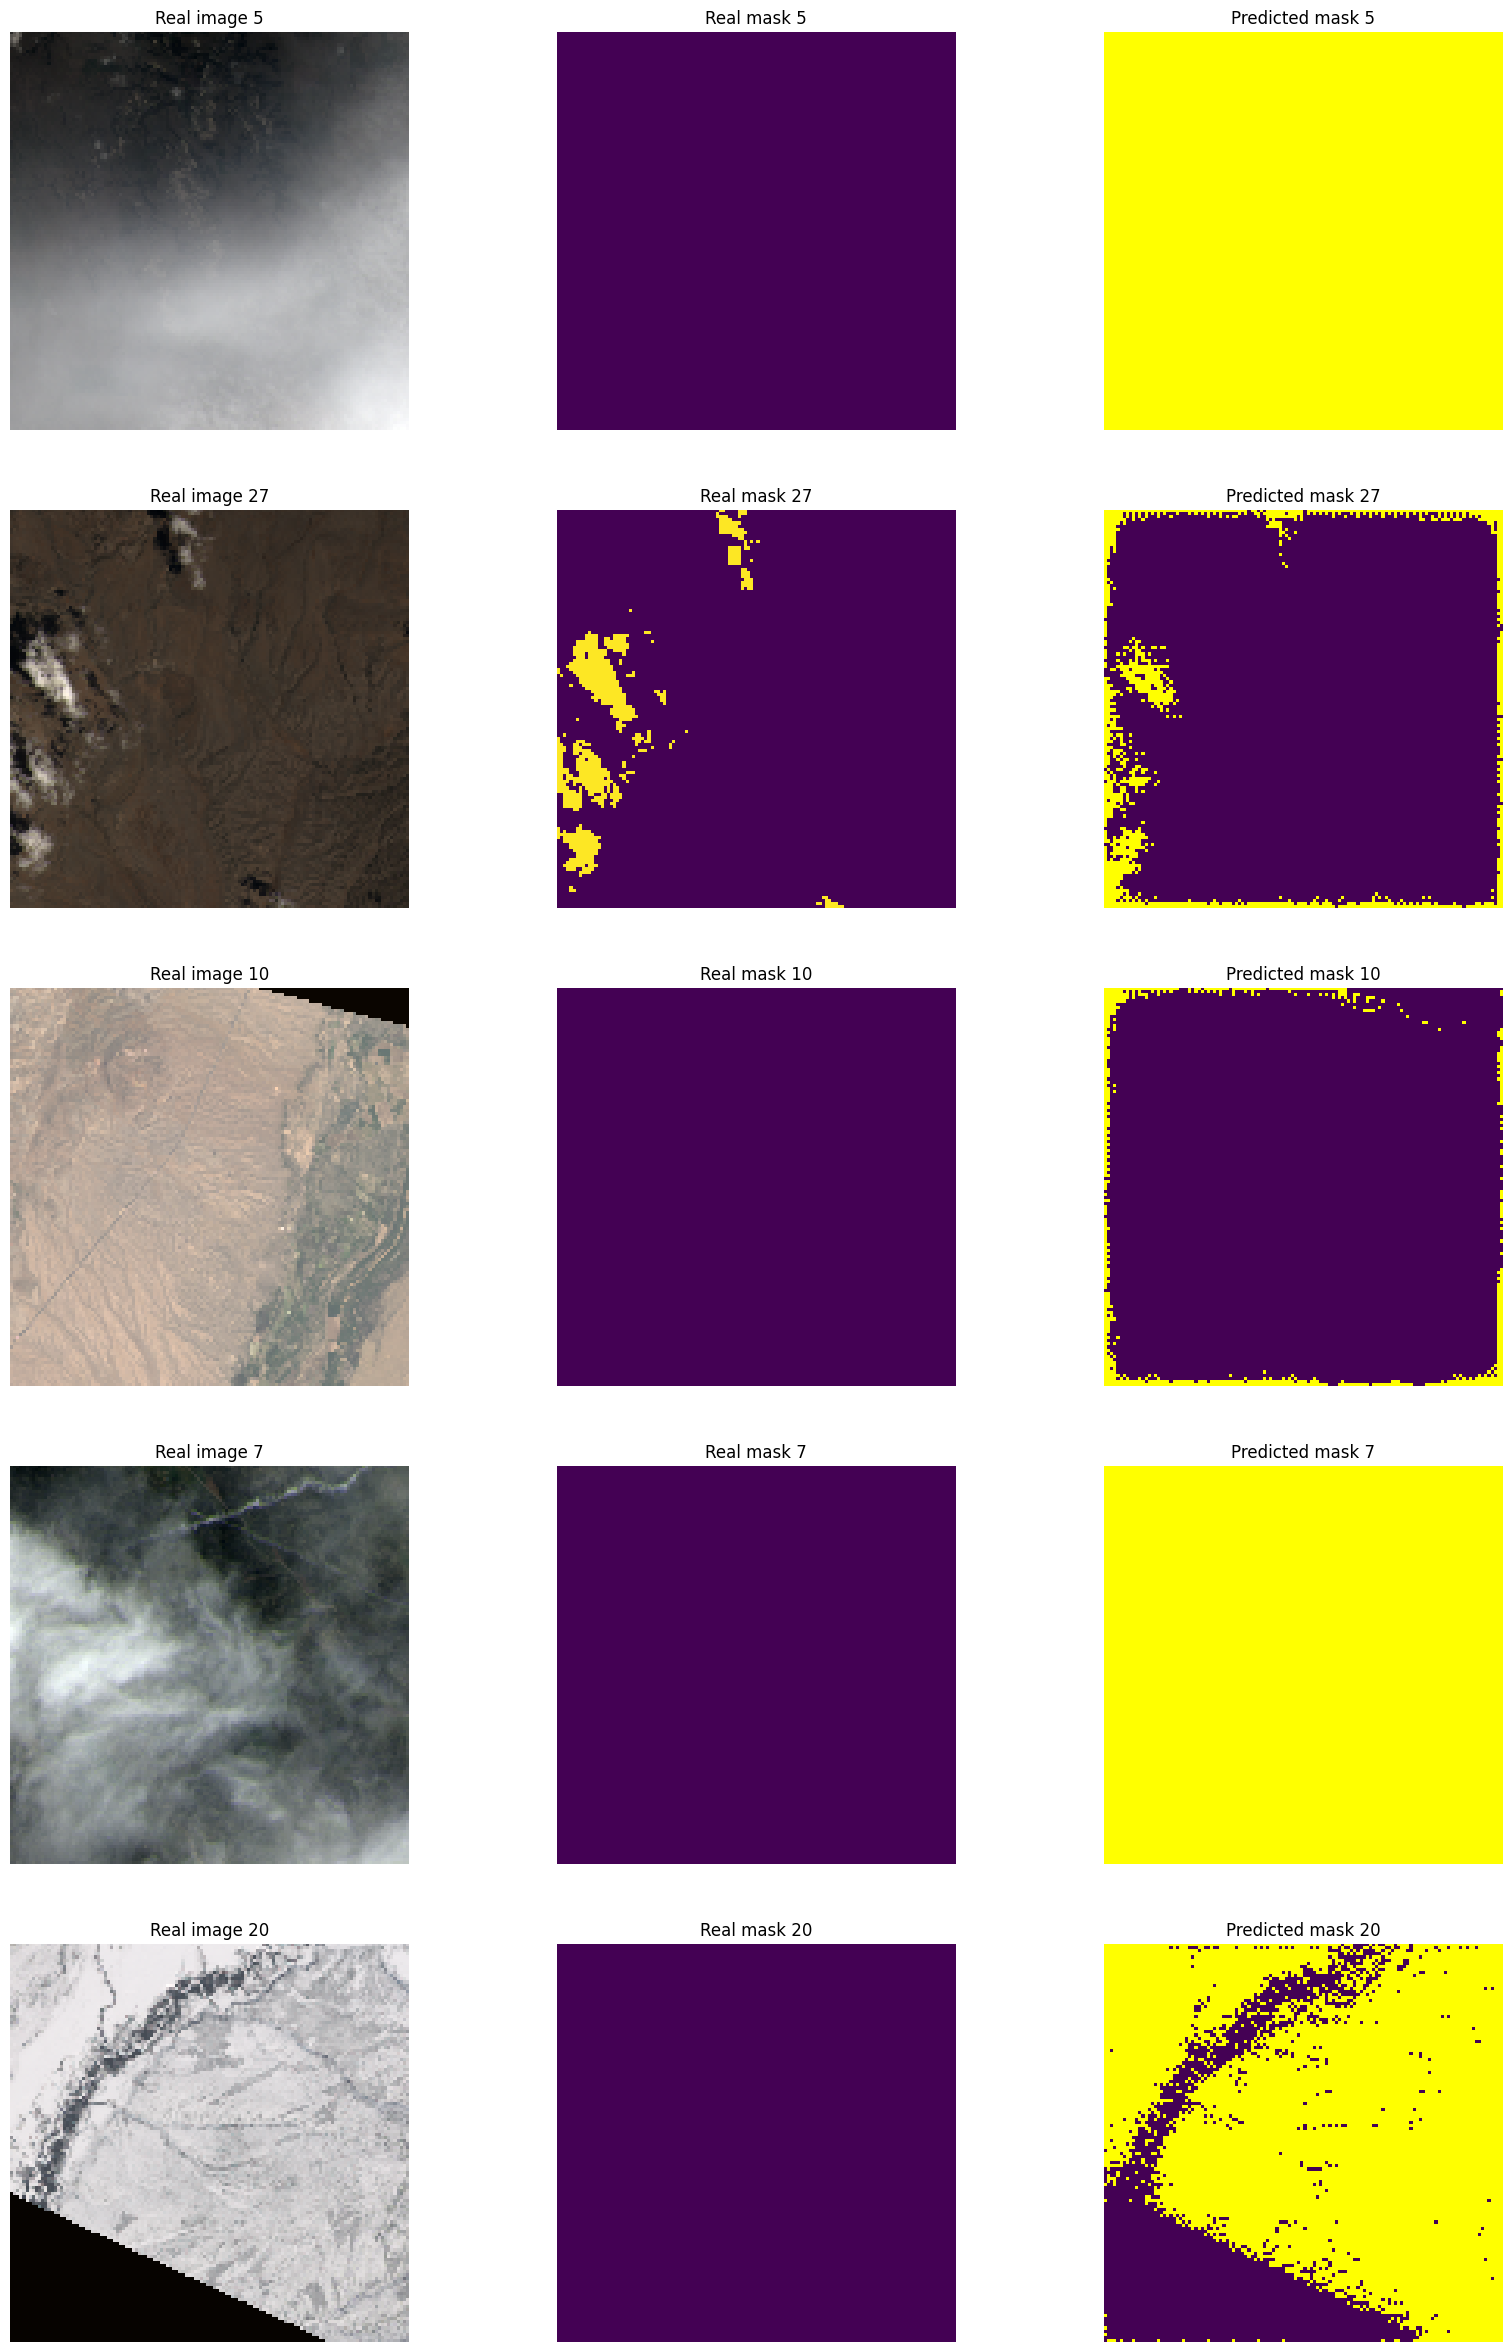

In [109]:
NUM_ELEM_SHOW = 5
RESULTS_RANGE = np.random.choice(31, NUM_ELEM_SHOW, replace=False)
print(f'Random results range: {RESULTS_RANGE}')

fig, axs = plt.subplots(NUM_ELEM_SHOW, 3, figsize=(20, 30))

for i, index in enumerate(RESULTS_RANGE):
    pred_img_mask_name = f'imgs/pred_{index}.png'
    pred_img_mask = Image.open(pred_img_mask_name)
    pred_img_mask = np.where(np.array(pred_img_mask) == 255, 1, 0)
    pred_img_mask = (pred_img_mask[:, :, 0])

    real_img, real_img_mask = sub_val[index]
    real_img = (real_img - real_img.min()) / (real_img.max() - real_img.min())
    real_img_mask = real_img_mask.numpy().astype(np.int64)

    axs[i, 0].imshow(real_img.permute(1, 2, 0))
    axs[i, 0].set_title(f'Real image {index}')
    axs[i, 0].set_axis_off()

    axs[i, 1].imshow(real_img_mask)
    axs[i, 1].set_title(f'Real mask {index}')
    axs[i, 1].set_axis_off()

    axs[i, 2].imshow(pred_img_mask, cmap=custom_cmap, vmin=0, vmax=1)
    axs[i, 2].set_title(f'Predicted mask {index}')
    axs[i, 2].set_axis_off()

print((real_img_mask))



[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


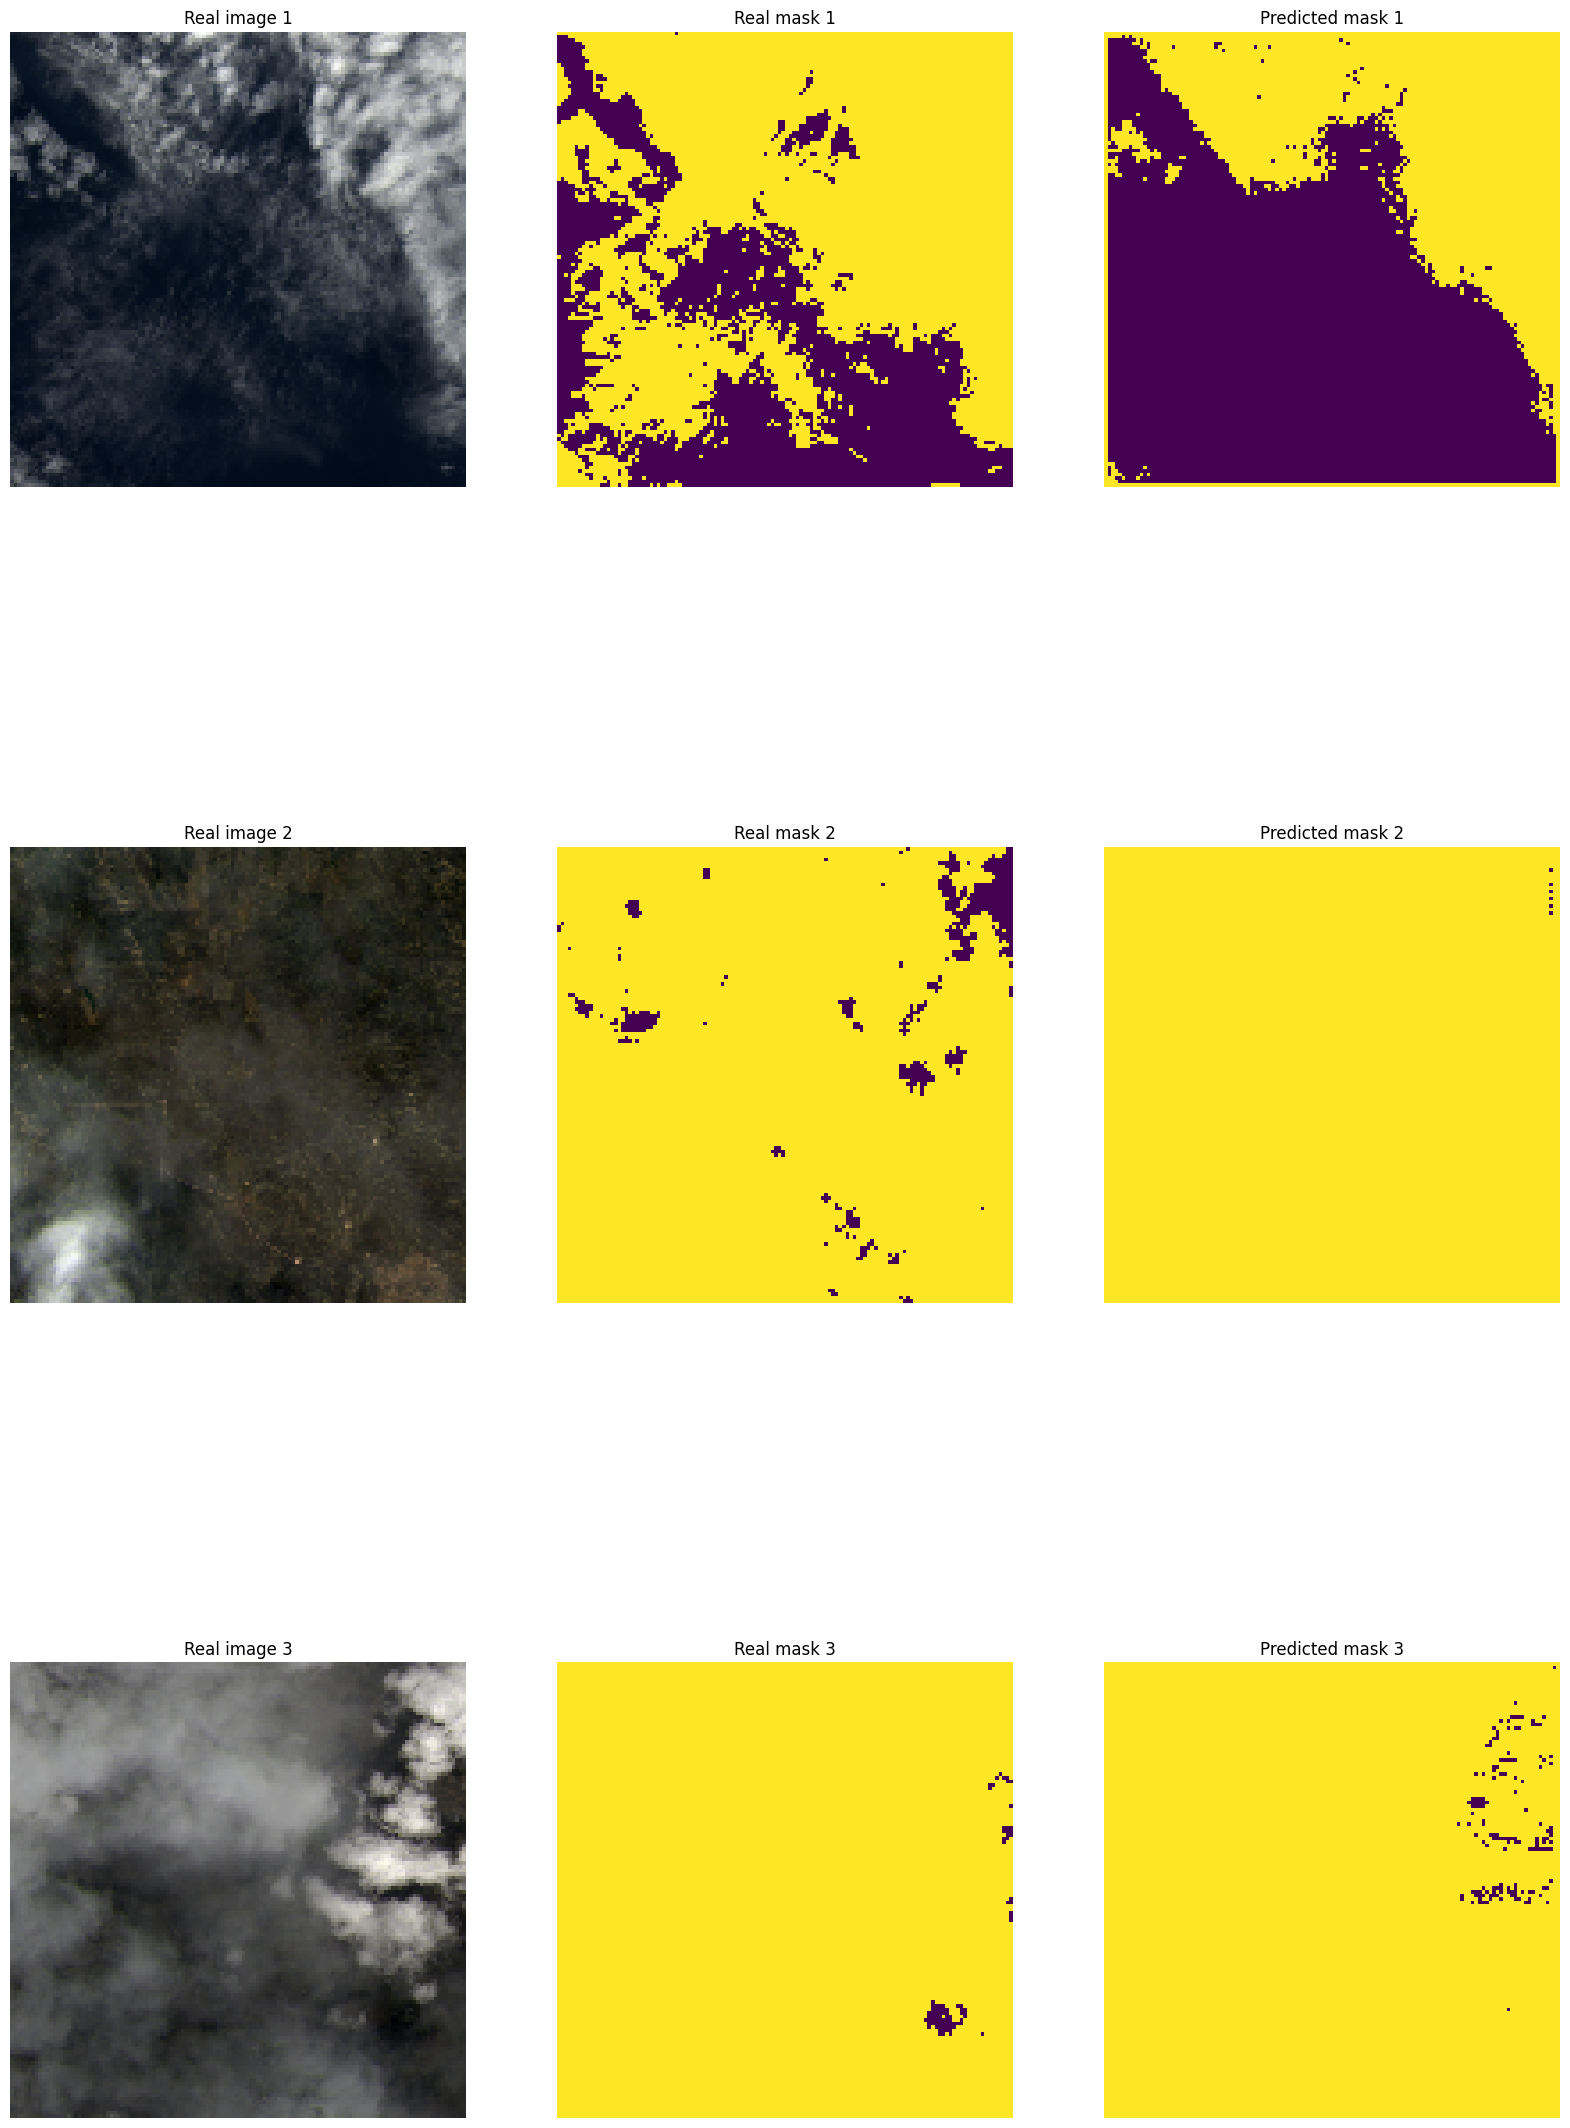

In [108]:
#TEST CMAP
fig, axs = plt.subplots(3, 3, figsize=(20, 30))
for i, index in enumerate([1, 2, 3]):
    pred_img_mask_name = f'imgs/pred_{index}.png'
    pred_img_mask = Image.open(pred_img_mask_name)
    pred_img_mask = np.where(np.array(pred_img_mask) == 255, 1, 0)
    pred_img_mask = (pred_img_mask[:, :, 0])

    real_img, real_img_mask = sub_val[index]
    real_img = (real_img - real_img.min()) / (real_img.max() - real_img.min())
    real_img_mask = real_img_mask.numpy().astype(np.int64)

    axs[i, 0].imshow(real_img.permute(1, 2, 0))
    axs[i, 0].set_title(f'Real image {index}')
    axs[i, 0].set_axis_off()

    axs[i, 1].imshow(real_img_mask)
    axs[i, 1].set_title(f'Real mask {index}')
    axs[i, 1].set_axis_off()

    axs[i, 2].imshow(pred_img_mask)
    axs[i, 2].set_title(f'Predicted mask {index}')
    axs[i, 2].set_axis_off()

print(data_train.to_mask(train_index))